HELLO FOLKS AND WELCOME TO THIS NOTEBOOK  !

We will be working on a solution to the ISIC challenge 2024. We have to create an algorithm capable of identifying skin cancer
using images obtained from 3D TB SCAN

The images are already cropped and saved in .jpg format. We also have a csv with metadata that could be useful to complete our task. Keep in mind that the deadline is September 6th

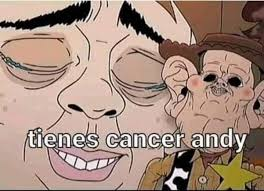

For more info, please feel free to go to the oficial page of the challenge in kaggle: https://www.kaggle.com/competitions/isic-2024-challenge/overview

In [26]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, Model

In [25]:
pd.set_option('display.max_columns', None)
data= pd.read_csv(r'C:\Users\migue\github_repository\isic-2024-challenge\train-metadata.csv')
data.head()

C:\Users\migue\AppData\Local\Temp\ipykernel_15960\3012818542.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv(r'C:\Users\migue\github_repository\isic-2024-challenge\train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


<Figure size 1000x600 with 0 Axes>

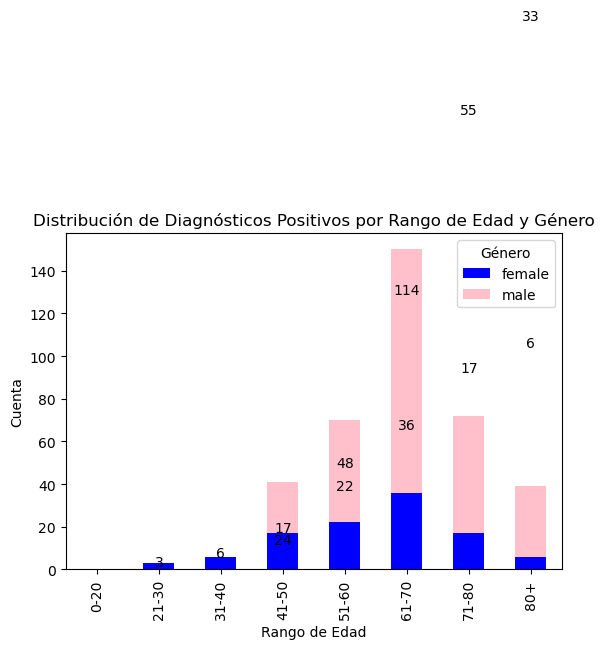

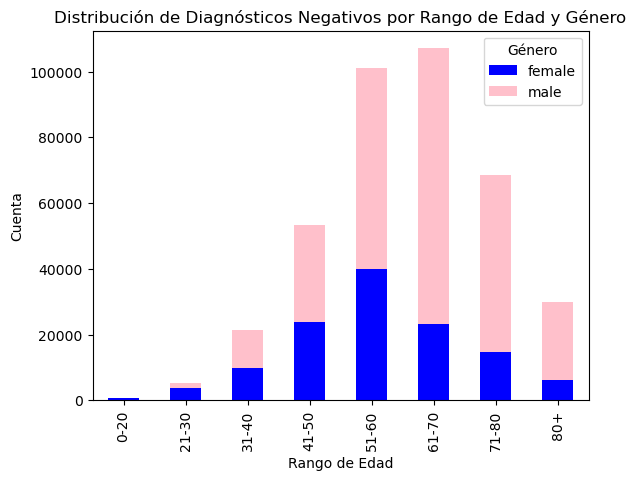

In [20]:
# Crear rangos de edad
bins = [0, 20, 30, 40, 50, 60, 70, 80, np.inf]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
data['Rango_Edad'] = pd.cut(data['age_approx'], bins=bins, labels=labels, right=False)

# Separar por diagnóstico
data_positivo = data[data['target'] == 1]
data_negativo = data[data['target'] == 0]

# Contar los valores por rango de edad y género para cada diagnóstico
positivos_counts = data_positivo.groupby(['Rango_Edad', 'sex']).size().unstack(fill_value=0)
negativos_counts = data_negativo.groupby(['Rango_Edad', 'sex']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))

# Graficar barras apiladas para diagnósticos positivos
positivos_counts.plot(kind='bar', stacked=True, color=['blue', 'pink'])
plt.title('Distribución de Diagnósticos Positivos por Rango de Edad y Género')
plt.xlabel('Rango de Edad')
plt.ylabel('Cuenta')
plt.legend(title='Género')
plt.subplots_adjust(bottom=0.15, top=0.85)
# Añadir etiquetas encima de las barras
for i in range(len(positivos_counts)):
    for j, value in enumerate(positivos_counts.iloc[i]):
        if value > 0:
            plt.text(i, positivos_counts.iloc[:i + 1, j].sum() - value / 2, str(value), ha='center', color='black')

plt.show()

# Graficar barras apiladas para diagnósticos negativos
negativos_counts.plot(kind='bar', stacked=True, color=['blue', 'pink'])
plt.title('Distribución de Diagnósticos Negativos por Rango de Edad y Género')
plt.xlabel('Rango de Edad')
plt.ylabel('Cuenta')
plt.legend(title='Género')


plt.show()

Text(0.5, 1.0, 'Distribución del genero en casos positivos')

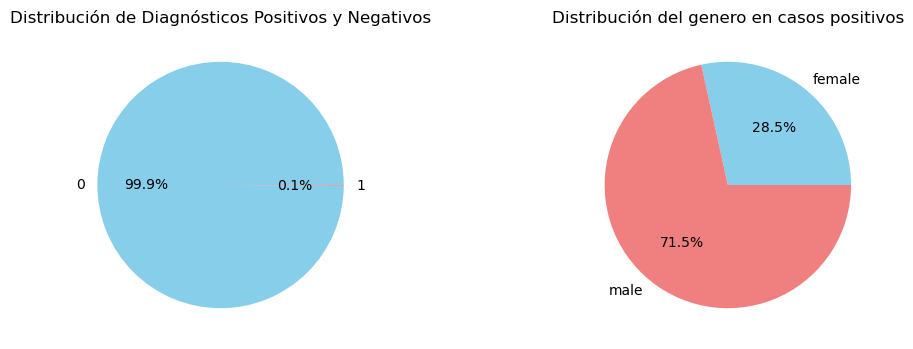

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
data['target'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribución de Diagnósticos Positivos y Negativos')
plt.ylabel('')  # Eliminar etiqueta del eje y
#plt.show()
plt.subplot(1, 2, 2)
genero = data_positivo.groupby(['sex']).size()
genero.plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribución del genero en casos positivos')

Here again we will have to handle class imbalance

In [28]:
data['target'].unique()

array([0, 1], dtype=int64)

In [27]:
minority_images = data_positivo['isic_id'].tolist()

image_folder = r'C:\Users\migue\github_repository\isic-2024-challenge\train-image\image'

# Inicializar una lista para almacenar las imágenes cargadas
images = []

# Cargar y preprocesar cada imagen
for image_name in minority_images:
    image_path = os.path.join(image_folder, image_name + '.jpg')
    img = load_img(image_path, target_size=(139, 139))  # Cargar la imagen y redimensionar
    img_array = img_to_array(img)  # Convertir la imagen a array numpy
    images.append(img_array)

# Convertir la lista de imágenes a un array numpy
X_minoritaria = np.array(images)

# Normalizar las imágenes para que los valores estén entre 0 y 1
X_minoritaria = X_minoritaria.astype('float32') / 255.0

print(f"Se han cargado {X_minoritaria.shape[0]} imágenes de la clase minoritaria.")

Se han cargado 393 imágenes de la clase minoritaria.


In [32]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Definir la dimensión latente
latent_dim = 16

# Encoder
input_img = layers.Input(shape=(139, 139, 3))  # Imágenes de 139x139 con 3 canales (RGB)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Ahora 70x70
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Ahora 35x35
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Ahora 18x18
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Reparametrización
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(18 * 18 * 128, activation='relu')(decoder_input)  # Regreso a 18x18
x = layers.Reshape((18, 18, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # Ahora 36x36
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # Ahora 72x72
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # Ahora 144x144
x = layers.Cropping2D(((2, 3), (2, 3)))(x)  # Recorta para regresar a 139x139
decoded_img = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)  # 3 canales para RGB

# Modelos
encoder = Model(input_img, [z_mean, z_log_var, z], name="encoder")
decoder = Model(decoder_input, decoded_img, name="decoder")

# Modelo VAE
output_img = decoder(encoder(input_img)[2])
vae = Model(input_img, output_img, name="vae")

# Función de pérdida
reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(input_img, output_img))
reconstruction_loss *= 139 * 139 * 3  # Ajuste para imágenes RGB (3 canales)
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5
vae_loss = reconstruction_loss + kl_loss

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Entrenar el VAE con los datos de la clase minoritaria
vae.fit(X_minoritaria, X_minoritaria, epochs=50, batch_size=32, shuffle=True)


Epoch 1/50
13/13 [==============================] - 31s 1s/step - loss: 39071.0508
Epoch 2/50
13/13 [==============================] - 12s 954ms/step - loss: 38821.5000
Epoch 3/50
13/13 [==============================] - 12s 952ms/step - loss: 38669.3281
Epoch 4/50
13/13 [==============================] - 12s 956ms/step - loss: 38558.9688
Epoch 5/50
13/13 [==============================] - 13s 959ms/step - loss: 38403.1328
Epoch 6/50
13/13 [==============================] - 12s 951ms/step - loss: 37809.1836
Epoch 7/50
13/13 [==============================] - 12s 948ms/step - loss: 37689.0430
Epoch 8/50
13/13 [==============================] - 12s 945ms/step - loss: 37585.7344
Epoch 9/50
13/13 [==============================] - 12s 945ms/step - loss: 37434.0391
Epoch 10/50
13/13 [==============================] - 12s 942ms/step - loss: 37412.4414
Epoch 11/50
13/13 [==============================] - 12s 943ms/step - loss: 37333.3789
Epoch 12/50
13/13 [==============================] - 12

1/1 [==============================] - 2s 2s/step


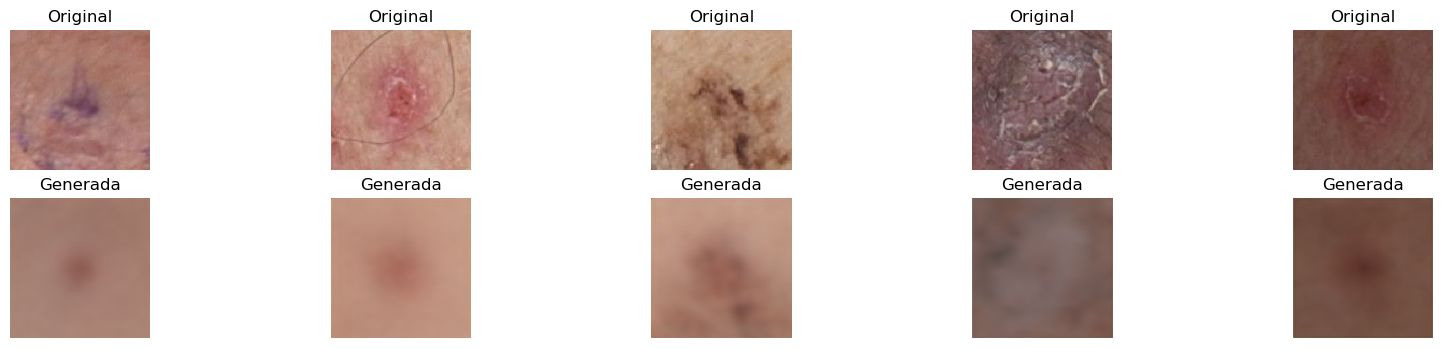

In [33]:
n = 5
# Seleccionar aleatoriamente imágenes del conjunto de datos
indices = np.random.choice(len(X_minoritaria), n)
imgs_originales = X_minoritaria[indices]
imgs_generadas = vae.predict(imgs_originales)

# Crear un gráfico para comparar las imágenes originales con las generadas
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs_originales[i])
    plt.title("Original")
    plt.axis("off")
    
    # Imagen generada
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_generadas[i])
    plt.title("Generada")
    plt.axis("off")
plt.show()